<a href="https://colab.research.google.com/github/Kaustuv1234/MTech_image_segmentation/blob/master/output_picie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchvision==0.4.0
!pip install scikit-learn==0.22.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement torchvision==0.4.0 (from versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.5.0, 0.6.0, 0.6.1, 0.7.0, 0.8.0, 0.8.1, 0.8.2, 0.9.0, 0.9.1, 0.10.0, 0.10.1, 0.11.0, 0.11.1, 0.11.2, 0.11.3, 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1)
ERROR: No matching distribution found for torchvision==0.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 21.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependenc

In [3]:
!git clone https://github.com/janghyuncho/PiCIE.git

Cloning into 'PiCIE'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 379 (delta 57), reused 57 (delta 57), pack-reused 320
Receiving objects: 100% (379/379), 14.85 MiB | 17.89 MiB/s, done.
Resolving deltas: 100% (236/236), done.


In [4]:
!mv PiCIE/* ./

In [6]:
import os 
import torch  
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision 
import numpy as np
import matplotlib.pyplot as plt 

from torchvision import transforms
from modules import fpn 
from PIL import Image 

# from torch.hub import load_state_dict_from_url

# 0. Prepare helper functions.

In [7]:
class Args:
    def __init__(self):
        pass
    
def collate_eval(batch):
    indice = [b[0] for b in batch]
    image = torch.stack([b[1] for b in batch])
    if batch[0][-1] is not None:
        label = torch.stack([b[2] for b in batch])

        return indice, image, label
    else:
        return indice, image
    
def get_score_histogram(label_trues, label_preds, n_class):
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    
    return hist

def compute_dist(featmap, metric_function, euclidean_train=True):
    centroids = metric_function.module.weight.data
    if euclidean_train:
        return - (1 - 2*metric_function(featmap)\
                    + (centroids*centroids).sum(dim=1).unsqueeze(0)) # negative l2 squared 
    else:
        return metric_function(featmap)

preprocess = transforms.Compose([transforms.ToTensor(), 
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                      std=[0.229, 0.224, 0.225])])


In [8]:
args = Args()

# Model
args.pretrain = True 
args.ssl = False 
args.ssl_dir = False 
args.arch = 'resnet18'

# Classifier
args.in_dim = 128
args.K = 6

# Dataloader
args.data_root = ''

# 1. Load PiCIE.

**NOTE**: Place the COCO version of PiCIE weight at "picie.pkl" 

In [9]:
picie_load = torch.load('/content/drive/MyDrive/datasets/checkpoint_best.pth.tar', 'cpu')

model = fpn.PanopticFPN(args)
model = nn.DataParallel(model)
model.load_state_dict(picie_load['state_dict'])

classifier = nn.Conv2d(args.in_dim, args.K, kernel_size=1, stride=1, padding=0, bias=True)
classifier = nn.DataParallel(classifier)
classifier.load_state_dict(picie_load['classifier1_state_dict'])

# Important ! 
model.eval()
classifier.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

DataParallel(
  (module): Conv2d(128, 6, kernel_size=(1, 1), stride=(1, 1))
)

# 2. Cluster the data with pre-trained PiCIE. 

In [10]:
# Run below.
# python prepare_histogram.py --data_root datasets --save_root results --stuff --thing --eval_path "picie.pkl"
# python prepare_histogram.py --data_root datasets/coco/ --save_root results/ --stuff --thing --eval_path "results/picie/train/1/augmented/res1=320_res2=640/jitter=True_blur=True_grey=True/equiv/h_flip=True_v_flip=False_crop=True/min_scale\=0.5/K_train=6_cosine/checkpoint_9.pth.tar"

# 3. For each cluster, assign a class label with the majority vote. 

In [11]:
histogram_train = torch.load('picie_histogram_coco.pkl')

histogram_train = histogram_train.astype(int)
histogram_train = torch.tensor(histogram_train).topk(1, dim=0)[1].flatten()

map_fn_train = lambda x: histogram_train[x]
mapper_train = np.vectorize(map_fn_train)

# 4. Visualize the predictions. 
Here is an image from the internet. We will visualize how well our model recognizes this image. 

In [12]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
  
# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [13]:
# !kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset
# !unzip -q /content/deepglobe-road-extraction-dataset.zip

In [14]:
def plot_image_grid(images, ncols=None, cmap='gray'):
    '''Plot a grid of images'''
    if not ncols:
        factors = [i for i in range(1, len(images)+1) if len(images) % i == 0]
        ncols = factors[len(factors) // 2] if len(factors) else len(images) // 4 + 1
    nrows = int(len(images) / ncols) + int(len(images) % ncols)
    imgs = [images[i] if len(images) > i else None for i in range(nrows * ncols)]
    f, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 2*nrows))
    axes = axes.flatten()[:len(imgs)]
    for img, ax in zip(imgs, axes.flatten()): 
        if np.any(img):
            if len(img.shape) > 2 and img.shape[2] == 1:
                img = img.squeeze()
            ax.imshow(img, cmap=cmap)

In [15]:
import os
import random
import gc
import matplotlib.pyplot as plt 

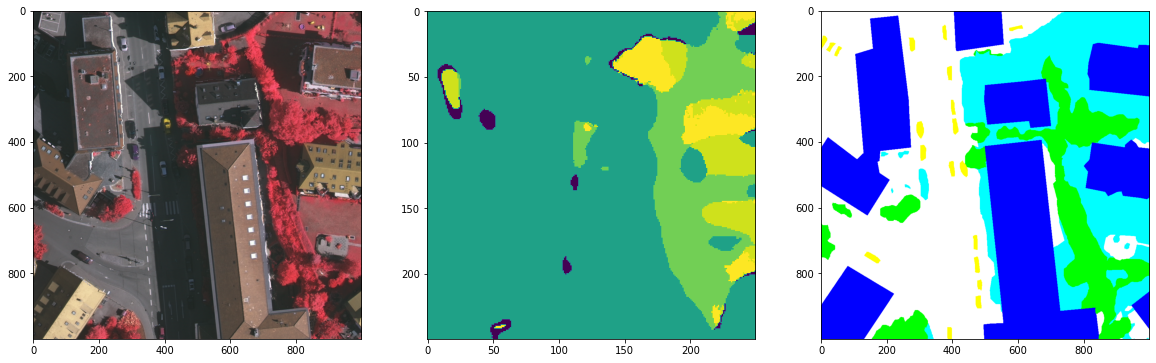

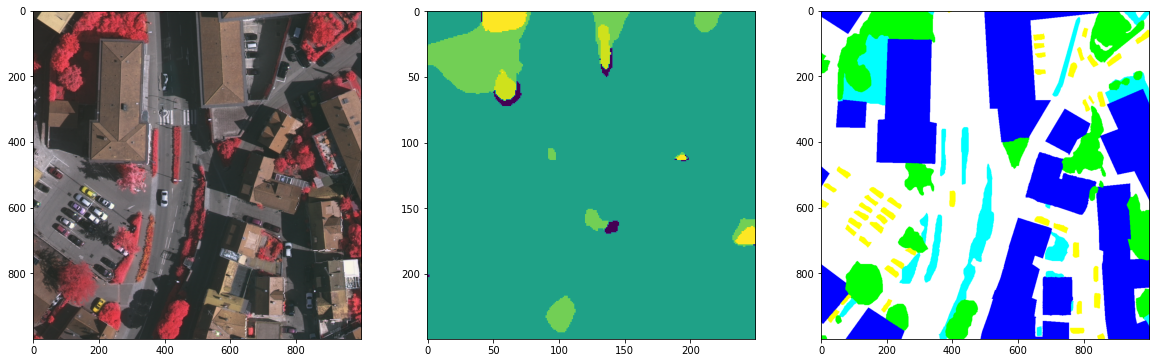

In [ ]:

imgg = '/content/drive/MyDrive/datasets/Vaihingen_train_test/images/'

gt = '/content/drive/MyDrive/datasets/Vaihingen_train_test/annotations/'

for file1 in os.listdir(imgg)[:10]:
    fig = plt.figure(figsize=(20, 20)) 
    img = Image.open(imgg + file1).convert('RGB')
    truth = Image.open(gt + file1).convert('RGB')
    img1 = preprocess(img)[None, :]
    out1 = model(img1)
    out1 = F.normalize(out1, dim=1, p=2)
    probs = compute_dist(out1, classifier)
    prediction = probs.topk(1, dim=1)[1]
    prediction = prediction.squeeze(0).squeeze(0)

    fig.add_subplot(1, 3, 1)
    plt.imshow(img)

    fig.add_subplot(1, 3, 2)
    plt.imshow(mapper_train(prediction))

    fig.add_subplot(1, 3, 3)
    plt.imshow(truth)

    plt.show()
    plt.close()
    gc.collect()

As seen above, our model is able to group semantically consistent pixeles.

# 5. Visualize the nearest neighbors. 

We further investigate by looking at the nearest neighbors from the validation set of COCO dataset. First, pick a query position on each image. They are *Animal* and *Building* classes, respectively.

In [ ]:
from matplotlib.patches import Rectangle 

fig = plt.figure(figsize=(10, 10))

fig.add_subplot(1, 3, 1)
plt.imshow(img_raw1)
ax = plt.gca()

# w, h
pos1  = (150, 50)
rect1 = Rectangle(pos1, 5, 5, linewidth=5, edgecolor='r', facecolor='none')
ax.add_patch(rect1)

fig.add_subplot(1, 3, 3)
plt.imshow(img_raw2)
ax = plt.gca()

# w, h
pos2  = (80, 120)
rect2 = Rectangle(pos2, 5, 5, linewidth=5, edgecolor='r', facecolor='none')
ax.add_patch(rect2)
plt.show()
print('\t Animal\t\t\t\t\t\tBuilding')

The feature maps are down-sized as below.

In [ ]:
print('Image 1 shape       : ', img_raw1.size[::-1])
print('Feature map 1 shape : ', lbl1.numpy().shape)
print('Image 2 shape       : ', img_raw2.size[::-1])
print('Feature map 2 shape : ', lbl2.numpy().shape)

We extract the pixel-level feature for each query and save. 

In [ ]:
# h, w
fpos1 = (pos1[1]*55//217, pos1[0]*73//289)
fpos2 = (pos2[1]*55//217, pos2[0]*36//144)

query1 = out1[:, :, fpos1[0], fpos1[1]]
query2 = out2[:, :, fpos2[0], fpos2[1]]
querys = torch.cat([query1, query2])

print('Image 1 query position : ', fpos1)
print('Image 2 query position : ', fpos2)

In [ ]:
# Save queries.
# np.save('querys.npy', querys.detach().numpy())

Now, we will look for the 5-nearest neighbors for each of these queries. The command below will retrieve the nearest neighbors of each query from the validation set of COCO images.

In [ ]:
# Run below.
# python retrieval.py --data_root datasets/coco --save_root . --stuff --thing --val_type val --K_test 5 --eval_path "picie.pkl"

In [ ]:
imglist, loclist = torch.load('picie_retrieval_result_coco.pkl')

In [ ]:
def show_neighbors(img_raw, q_loc, imglist_c, loclist_c):
    fig = plt.figure(figsize=(12, 12))
    fig.add_subplot(1, 3, 2)
    plt.imshow(img_raw)
    ax = plt.gca()

    rect = Rectangle(q_loc, 5, 5, linewidth=8, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

    fig = plt.figure(figsize=(20, 100))
    for i, (img, loc) in enumerate(zip(imglist_c, loclist_c)):
        fig.add_subplot(1, 5, i+1)
        plt.imshow(img)
        ax = plt.gca()

        _, h, w = loc
        rect = Rectangle((4*w, 4*h), 5, 5, linewidth=8, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

print('\n\n\n')
print('\t\t\t\t\t\t\tAnimal')
show_neighbors(img_raw1, pos1, imglist[0], loclist[0])
print('\n\n\n')
print('\t\t\t\t\t\t\tBuilding')
show_neighbors(img_raw2, pos2, imglist[1], loclist[1])

Both *Animal* and *Building* have semantically consistent nearest neighbors. 